# Phase 4 Project

### Business Problem

Company Zen has been marketing and selling Apple and Google products for an year now. One of their main platform is Twitter and they have hired me to build a model to help them classify the sentiments on the product offering so as to enable them make informed decision to strengthen or reassess their relationships with Apple and Google based on how customers are responding to the products.

### Business Understanding

Understanding customer feel and think on products is very crucial as it impacts the marketing and product offering. Twitter offers real-time insights that would help the company react quicky to feedback and possible recover service. Identifying trends and sentiment patterns early, will enable Zen outpace competitors in refining their campaigns and address customer pain points.
See below objectives that the model seeks to answer:
* Develop a model to predict the positive and negative sentiments?
* What products have the best and worst sentiments?
* Should Company Zen continue this partneship with Apple and Google?

### Data Understanding

The dataset was downloaded from CrowdFlower and is stored in the data folder. Human raters rated the sentiments in over 9,000 Tweets as positive, negative, or neither. See the breakdown of the columns the data is in.

**Tweet_text** -- actual text of the tweets

**Emotion_in_tweet_is_directed_at** -- who or what the emotion expressed in the tweet is directed at

**Is_there_an_emotion_directed_at_a_brand_or_product** -- whether the tweet contains an emotion directed at a specific brand or product


#### Import Libraries

In [34]:
#Import relevant libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
import re
nltk.download('punkt')
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.sparse.csr import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Load & Inspect Data

In [35]:
# Load the dataset
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')
# Preview the first five rows
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


* The column names are so long. Let us proceed to **rename** for ease of access

In [36]:
# Rename columns for ease of access
df.rename(columns={
    'tweet_text': 'Text',
    'emotion_in_tweet_is_directed_at': 'Product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'
}, inplace=True)

# Preview the renamed columns
df.head()

,Text,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [37]:
#To view the shape of the dataset
df.shape

(9093, 3)

* We have 9093 tweet texts and 3 columns renamed as above.

In [38]:
#To view the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       9092 non-null   object
 1   Product    3291 non-null   object
 2   Sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


* We can view the datatype as object for the three columns and some missing values detected under the Non-null count which we shall further investigate.

#### Checking For Duplicates


In [39]:
# Check the number of duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")
# Remove duplicate rows
df_cleaned = df.drop_duplicates()

Number of duplicate rows: 22


#### Checking For Missing Values

In [40]:
#To view the missing values from the cleaned dataset
df_cleaned.isnull().sum()

Text            1
Product      5789
Sentiment       0
dtype: int64

* We note that some of the tweets have the product keywords found in the second column. As a result, we will search for the keywords from the tweet column and where we find the products we shall fill the null values with it. This will help us deal with smaller numbers of null values in this column

In [54]:
# Example list of product names
product_keywords = ['iPad', 'Apple', 'Google', 'iPhone', 'Android App', 'Android', 'iPad or iPhone App']

# Function to extract product name from tweet text
def extract_product(text):
    if isinstance(text, str):  # Check if the text is a valid string
        for product in product_keywords:
            if product.lower() in text.lower():
                return product
    return np.nan  # Return NaN if no product is found or text is not a string

df_cleaned['Product'] = df_cleaned.apply(
    lambda row: extract_product(row['Text']) if pd.isnull(row['Product']) else row['Product'], axis=1
)

# Display the filled data
print(df_cleaned.head(10))

                                                Text             Product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   
5  @teachntech00 New iPad Apps For #SpeechTherapy...                iPad   
6                                                NaN                 NaN   
7  #SXSW is just starting, #CTIA is around the co...             Android   
8  Beautifully smart and simple idea RT @madebyma...  iPad or iPhone App   
9  Counting down the days to #sxsw plus strong Ca...               Apple   

          Sentiment  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion  
5           Neutral  
6        

In [55]:
df_cleaned.isnull().sum()

Text           1
Product      760
Sentiment      0
dtype: int64

* Since we have only one null row under the Text column we shall proceed to drop this null value then fill the product null values with a placeholder as the count of null values is actually too high and the product is important to us.

In [56]:
# Drop missing values in 'Text' column
df_cleaned = df_cleaned.dropna(subset=['Text'])

# Fill missing values in 'Product' with a placeholder since we have 5789 null values.
df_cleaned['Product'].fillna('Unknown Product', inplace=True)

# Check if missing values are handled
print(df_cleaned.isnull().sum())

Text         0
Product      0
Sentiment    0
dtype: int64


Neutral             5375
Positive emotion    2970
Negative emotion     569
I can't tell         156
Name: Sentiment, dtype: int64
--------------
Percentage of Distribution
Neutral             59.261301
Positive emotion    32.745314
Negative emotion     6.273429
I can't tell         1.719956
Name: Sentiment, dtype: float64


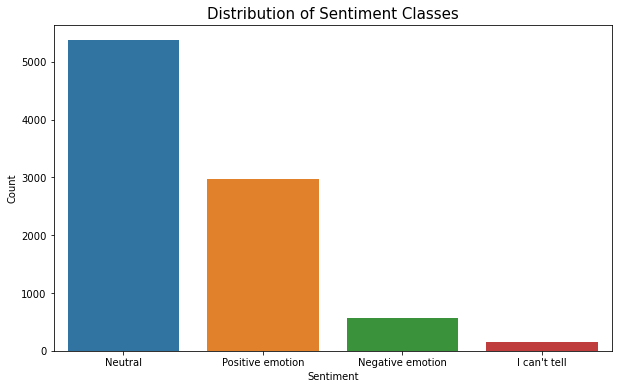

In [57]:
#To view the count of each unique features of our target variable
sentiment_counts = df_cleaned['Sentiment'].value_counts()
sentiment_counts_perc = df_cleaned['Sentiment'].value_counts(normalize=True)
print(sentiment_counts)
print('--------------')
print('Percentage of Distribution')
print(sentiment_counts_perc*100)
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Add labels and title
plt.xlabel('Sentiment', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Distribution of Sentiment Classes', fontsize=15)

# Show the plot
plt.show()

* Most of the data reflects neutral or no emotional response about 60%, followed by a significant share of positive sentiment 33%, and a much smaller share of negative emotions 6%. The "I can't tell" category is marginal about 1.7%.

In [58]:
#Decided to replace the no emotion toward branch or product with Neutral for use of interpretation
df_cleaned['Sentiment'] = df_cleaned['Sentiment'].replace('No emotion toward brand or product', 'Neutral')
df_cleaned['Sentiment'].value_counts() #Review the value counts of the classes of sentiments

Neutral             5375
Positive emotion    2970
Negative emotion     569
I can't tell         156
Name: Sentiment, dtype: int64

iPad                               2512
Google                             2131
Apple                              1382
iPhone                             1121
Unknown Product                     759
iPad or iPhone App                  469
Other Google product or service     293
Android                             265
Android App                         103
Other Apple product or service       35
Name: Product, dtype: int64


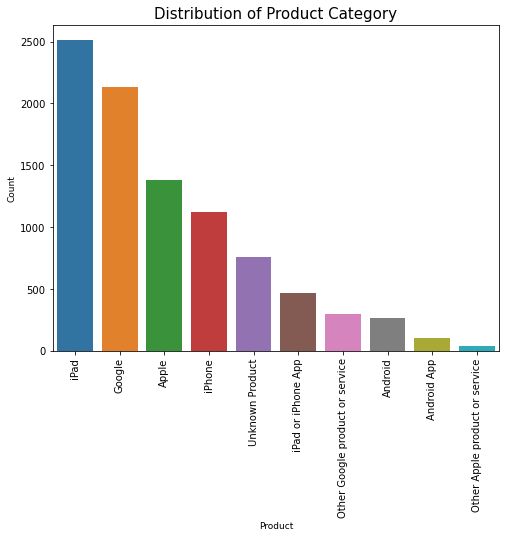

In [59]:
#To view the unique features of our product
product_counts = df_cleaned['Product'].value_counts()
print(product_counts)
# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=product_counts.index, y=product_counts.values)

# Add labels and title
plt.xlabel('Product', fontsize=9)
plt.ylabel('Count', fontsize=9)
plt.title('Distribution of Product Category', fontsize=15)
plt.xticks(rotation=90)

# Show the plot
plt.show()

#### Data Preprocessing
Here we will focus on the column Text containing the texts of the tweet and Perform Data Cleaning and Exploratory Data Analysis with nltk. Before that let us split our data.

In [60]:
# Split into train+val and test sets (90% train+val, 10% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(df_cleaned[['Text', 'Product']], df_cleaned['Sentiment'], test_size=0.1, random_state=42)

# Then, split train+val into training and validation sets (85% train, 15% val)
X_train_final, X_val, y_train_final, y_val = train_test_split(df_cleaned[['Text', 'Product']], df_cleaned['Sentiment'], test_size=0.15, random_state=42)

# Check the sizes of the splits
print(f"Training set size: {X_train_final.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (7709, 2)
Validation set size: (1361, 2)
Test set size: (907, 2)


In [61]:
# Define stop words and initialize the Porter Stemmer
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()

# Updated preprocessing function to include stemming
def preprocess_text(text):
    # Lowercase the text
    text = text.lower() 
    
    # Remove Twitter usernames, punctuation, and digits
    text = re.sub(r'@\w+|[^\w\s]|[\d]+', '', text)  # Combined pattern
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    tokens = [porter_stemmer.stem(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

# Preprocess the 'Text' column for each split
X_train_final['cleaned_text'] = X_train_final['Text'].apply(preprocess_text)
X_val['cleaned_text'] = X_val['Text'].apply(preprocess_text)
X_test['cleaned_text'] = X_test['Text'].apply(preprocess_text)

# Display the cleaned text for the training set
print(X_train_final['cleaned_text'].head())

5488    rt sxsw check tokii mapl leaf digit loung link...
3012    ahh wonder news rt ipad avail onlin order go g...
7191    help clean organ newscont great job ipad owner...
8335    franken take shot appl app process cc stribpol...
5053    rt manufactur serendip quothav access inform m...
Name: cleaned_text, dtype: object


#### Text Vectorization

In [62]:
# Initialize the TF-IDF Vectorizer (limit to top 5000 features)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data, and transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_final['cleaned_text'])
X_val_tfidf = tfidf_vectorizer.transform(X_val['cleaned_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['cleaned_text'])

# Display the shape of the TF-IDF matrices
print(f"TF-IDF training data shape: {X_train_tfidf.shape}")
print(f"TF-IDF validation data shape: {X_val_tfidf.shape}")
print(f"TF-IDF testing data shape: {X_test_tfidf.shape}")

TF-IDF training data shape: (7709, 5000)
TF-IDF validation data shape: (1361, 5000)
TF-IDF testing data shape: (907, 5000)


#### Modeling

In [64]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
logreg_model = LogisticRegression(max_iter=10000)

# Train the model on the training data
logreg_model.fit(X_train_tfidf, y_train_final)

# Predict the sentiment on the val set
y_pred_logreg = logreg_model.predict(X_val_tfidf)
acc = accuracy_score(y_pred_logreg, y_val)
print(acc)

0.6891991182953711
